In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import rasterio as rio
from FyeldGenerator import generate_field

In [42]:
## This cell packs helpers to add noise to the image
def gaussian_distribution(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

# This is just a helper that generates the power spectrum of the GRF
# Power spectrum of a GRF is the FFT of its covariance - details in the MD cell below
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)
    

    return Pk

def noised_image(input_image, gaussian_random_field):
    return input_image + gaussian_random_field

Let's take Romain's 2022 IEEE paper's variogram (call it $G$ because we'll only look at short ranges) and simplify it a bit :


$ G(s,r,d) = s(1-e^{\frac{2d}{r}^{2}})$

with $s$ being the sill, $r$ the range, and $d$ the reciprocal distance between two samples.

Assuming $s=1$ and $r \approx 100$ m (we here define the range of the variogram as 1 pixel, this is not true, but it is for the sake of simplicity) we can write the covariance function:


$C(d) = e^{\frac{2d}{r}^2}$ 

I still wrote $r$ for the sake of readbility but note that since we defined it as constant, $C(d)$ does not depend on $r$.

And from that we can write our power spectrum as the FFT of $C(d)$.


In [43]:
#This cell prints a list of the different discrete wavelets - I use biorthogonal (Cohen-Daubechies-Fauveau) wavelets because they are used for stuff like JPEG2000 compression
#print(pywt.wavelist(kind='discrete'))

In [44]:
#Just a plotting function
def plot_wvt_xform(coeffs):
    titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
    LL, (LH, HL, HH) = coeffs
    fig = plt.figure(figsize=(24, 6))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()

In [45]:
src = rio.open("/home/gregguillet/VSCode/edge_detection/N46W122_2000-01-01_2020-01-01_clip.tif")
img_array = src.read(1, masked=True)


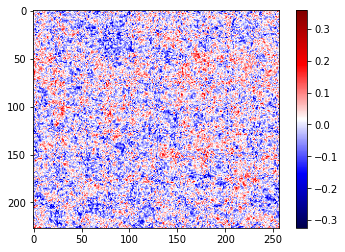

In [46]:
gaussian_random_rield = generate_field(gaussian_distribution, power_spectrum=Pkgen(1), shape=np.shape(img_array))*10
plt.imshow(gaussian_random_rield, cmap='seismic')
plt.colorbar()

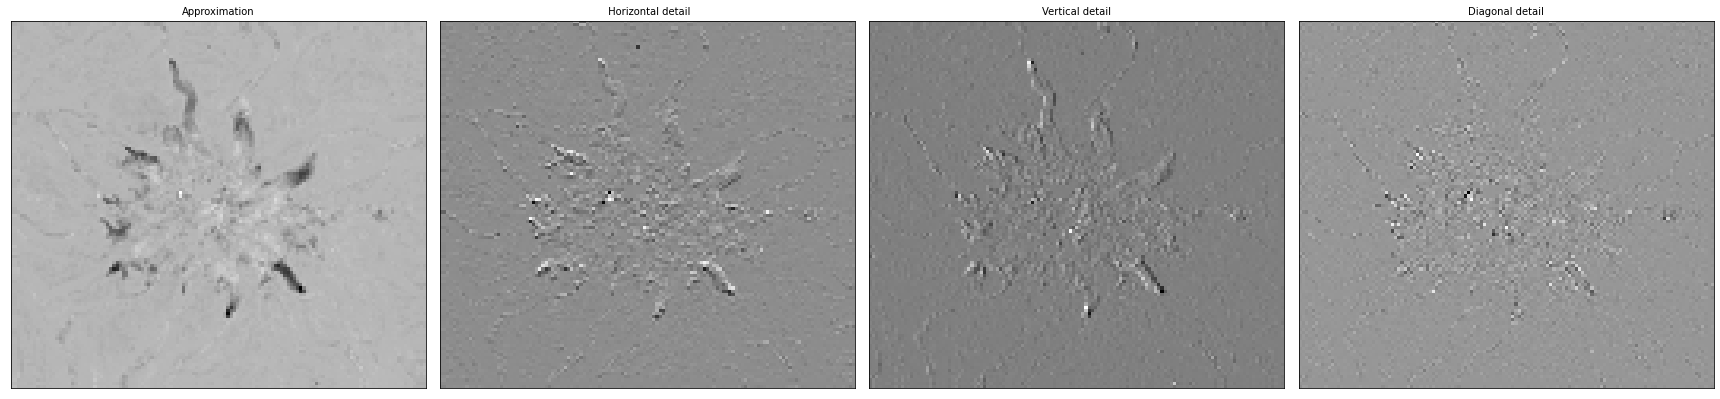

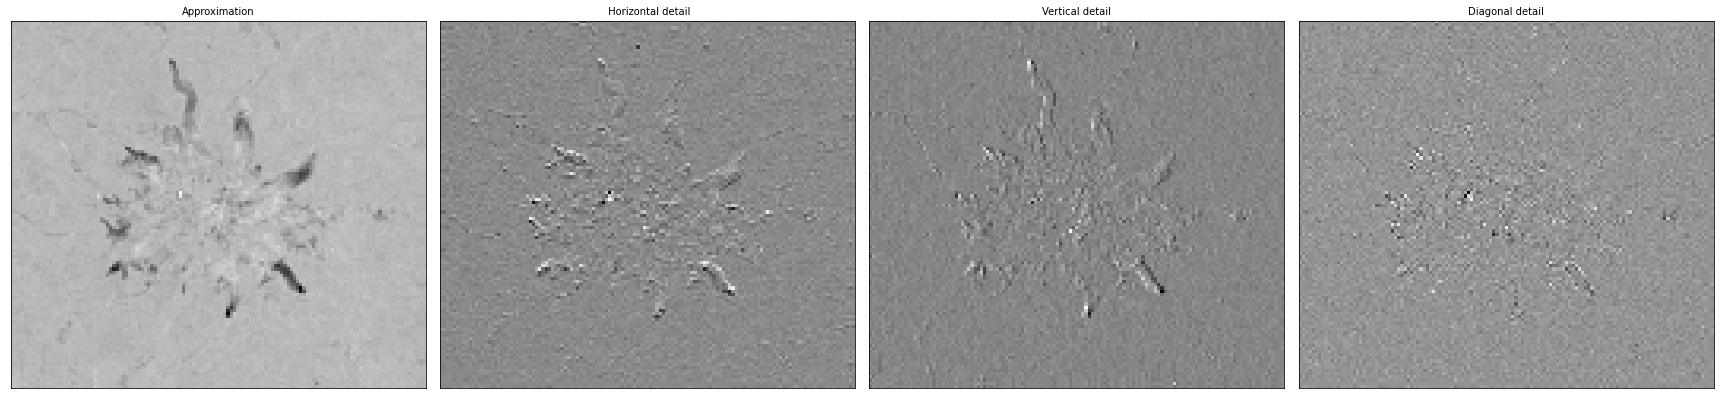

In [47]:
coeffs_orig = pywt.dwt2(img_array, 'bior1.3')
coeffs_noise = pywt.dwt2(noised_image(img_array, gaussian_random_field=gaussian_random_rield), 'bior1.3')
plot_wvt_xform(coeffs_orig)
plot_wvt_xform(coeffs_noise)
